# Quickstart

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# uncomment to disable NVIDIA GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# or pick the device (cpu, gpu, and tpu)
# os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
os.environ['JAX_ENABLE_X64']= 'False'

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA A100-PCIE-40GB


In [3]:
import BFast #for computing bispectra with jax on gpu, see github.com/tsfloss/BFast
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
jax.numpy.set_printoptions(precision=8)

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, linear_transfer,
    white_noise, linear_modes, transfer,
    lpt,
    nbody,
    scatter
)
from pmwd.vis_util import simshow
from pmwd.spec_util import powspec
from pmwd.pm_util import fftfreq, fftfwd, fftinv

In [4]:
BoxSize = 1000
grid = 512
kF = 2*np.pi/BoxSize
cell_spacing = BoxSize / grid
cell_spacing

1.953125

## Simulate Forward

`Configuration` stores static configuration and parameters for which we do not need derivatives.

In [5]:
if jax.lib.xla_bridge.get_backend().platform == 'gpu':
    ptcl_spacing = cell_spacing  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (grid,) * 3
else:
    ptcl_spacing = cell_spacing  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (grid,) * 3

conf = Configuration(ptcl_spacing,ptcl_grid_shape,mesh_shape=1,a_start=1/(1+127.),a_nbody_maxstep=0.09,a_stop=1.,lpt_order=2)  # 2x mesh shape

2025-01-09 16:13:28.206426: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=1.953125,
              ptcl_grid_shape=(512, 512, 512),
              mesh_shape=(512, 512, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.0078125,
              a_stop=1.0,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.09,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
Simulating 13

`Cosmology` stores interesting parameters, whose derivatives we need.

In [7]:
cosmo_LC_p = Cosmology(conf, A_s_1e9=2.1006, n_s=0.9624, Omega_m=0.3175, Omega_b=0.049, h=0.6711,f_nl_loc_=100.,)
cosmo_LC_m = Cosmology(conf, A_s_1e9=2.1006, n_s=0.9624, Omega_m=0.3175, Omega_b=0.049, h=0.6711,f_nl_loc_=-100.,)

# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo_LC_p,cosmo_LC_m)

Cosmology(A_s_1e9=Array(2.101, dtype=float64),
          n_s=Array(0.962, dtype=float64),
          Omega_m=Array(0.318, dtype=float64),
          Omega_b=Array(0.049, dtype=float64),
          h=Array(0.671, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          f_nl_loc_=Array(100., dtype=float64),
          transfer=None,
          growth=None,
          varlin=None) Cosmology(A_s_1e9=Array(2.101, dtype=float64),
          n_s=Array(0.962, dtype=float64),
          Omega_m=Array(0.318, dtype=float64),
          Omega_b=Array(0.049, dtype=float64),
          h=Array(0.671, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          f_nl_loc_=Array(-100., dtype=float64),
          transfer=None,
          growth=None,
          varlin=None)


``boltzmann`` computes the transfer and growth functions and caches them in ``Cosmology``.

The first run is slower because it includes the **JIT compilation** time. JAX uses **asynchronous dispatch** to hide Python overheads. To measure the true cost, use ``DeviceArray.block_until_ready()`` to wait for the computation to complete.

In [8]:
cosmo_LC_p = boltzmann(cosmo_LC_p, conf)
cosmo_LC_m = boltzmann(cosmo_LC_m, conf)

In [9]:
cosmo_LC_p.sigma8

Array(0.834, dtype=float64)

Generate a white noise field, and scale it with the linear power spectrum:

In [10]:
# seed = 2
# modes_white = white_noise(seed, conf)

modes_white = np.load("/home/fs72085/tsfloss/data/Quijote_Density_256/sim_0_white_512.npy")

CPU times: user 653 ms, sys: 167 ms, total: 820 ms
Wall time: 873 ms


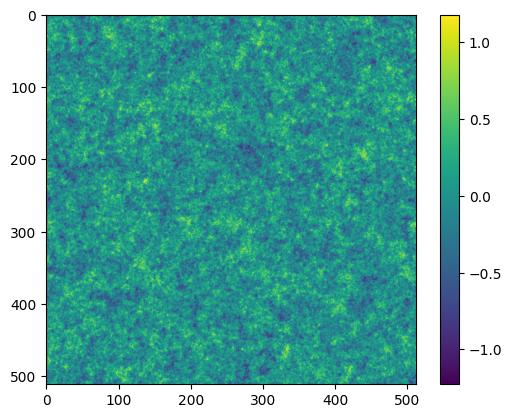

In [11]:
%time modes_LC_p = linear_modes(modes_white, cosmo_LC_p, conf)

plt.imshow(fftinv(modes_LC_p,shape=conf.ptcl_grid_shape,norm=conf.ptcl_spacing).mean(0))
plt.colorbar()

CPU times: user 26.7 ms, sys: 836 μs, total: 27.5 ms
Wall time: 26.9 ms


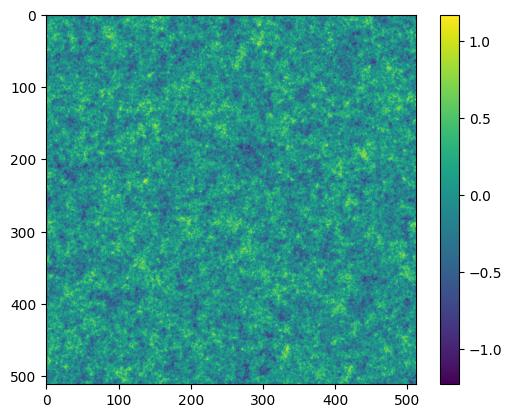

In [12]:
%time modes_LC_m = linear_modes(modes_white, cosmo_LC_m, conf)

plt.imshow(fftinv(modes_LC_m,shape=conf.ptcl_grid_shape,norm=conf.ptcl_spacing).mean(0))
plt.colorbar()

Solve LPT at some early time:

In [13]:
ptcl_LC_p, obsvbl_LC_p = lpt(modes_LC_p, cosmo_LC_p, conf)
ptcl_LC_p.disp.std(), ptcl_LC_p.vel.std()

(Array(0.058, dtype=float32), Array(0.003, dtype=float32))

In [14]:
ptcl_LC_m, obsvbl_LC_m = lpt(modes_LC_m, cosmo_LC_m, conf)
ptcl_LC_m.disp.std(), ptcl_LC_m.vel.std()

(Array(0.058, dtype=float32), Array(0.003, dtype=float32))

Finally, N-body time integration from the LPT initial conditions:

In [15]:
# ptcl_LC_p, obsvbl_LC_p = nbody(ptcl_LC_p, obsvbl_LC_p, cosmo_LC_p, conf)
# ptcl_LC_p.disp.std(), ptcl_LC_p.vel.std()

In [16]:
# ptcl_LC_m, obsvbl_LC_m = nbody(ptcl_LC_m, obsvbl_LC_m, cosmo_LC_m, conf)
# ptcl_LC_m.disp.std(), ptcl_LC_m.vel.std()

Scatter the particles to mesh to get the density field, and plot a slab's 2D projection:

In [17]:
dens_LC_p = scatter(ptcl_LC_p, conf,)-1.
# simshow(dens_LC_p[:].mean(axis=0), norm='CosmicWebNorm');

In [18]:
dens_LC_m = scatter(ptcl_LC_m, conf,)-1.
# simshow(dens_LC_m[:8].mean(axis=0), norm='CosmicWebNorm');

In [19]:
df_LC_p_Q = np.load("/home/fs72085/tsfloss/data/Quijote_Density_256/df_m_256_CIC_LC_p_0_z=127.npy")
df_LC_m_Q = np.load("/home/fs72085/tsfloss/data/Quijote_Density_256/df_m_256_CIC_LC_m_0_z=127.npy")

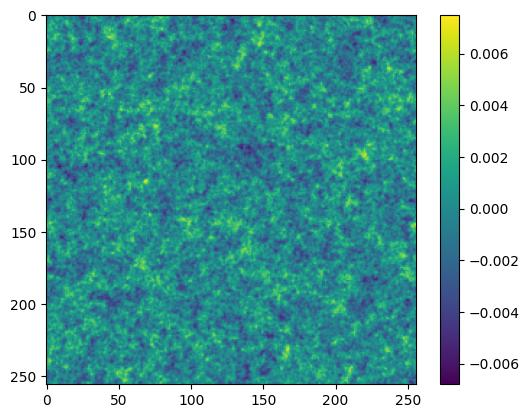

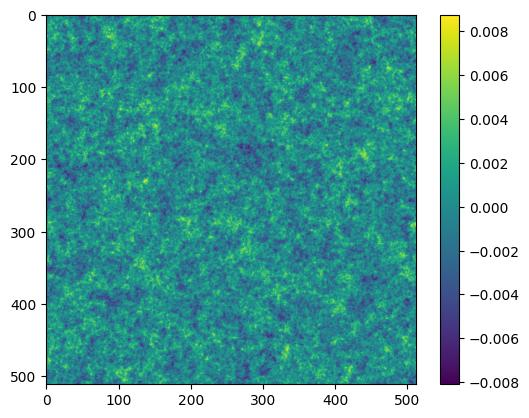

In [20]:
plt.imshow(df_LC_p_Q.mean(0))
plt.colorbar()
plt.show()

plt.imshow(dens_LC_p.mean(0))
plt.colorbar()
plt.show()

CPU times: user 367 ms, sys: 13.9 ms, total: 381 ms
Wall time: 385 ms
CPU times: user 668 μs, sys: 69 μs, total: 737 μs
Wall time: 602 μs
CPU times: user 842 ms, sys: 129 ms, total: 971 ms
Wall time: 987 ms
CPU times: user 4.7 ms, sys: 109 μs, total: 4.81 ms
Wall time: 4.67 ms


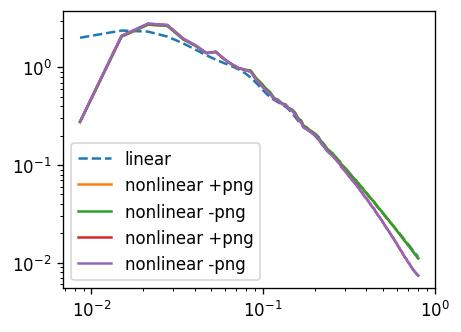

In [21]:
kQ, PQ = np.load(f'/home/fs72085/tsfloss/data/Quijote_Measurements_npy/Pk_fiducial_z0.npy').mean(0)[:,:2].T
%time k, P_LC_p, _, _ = powspec(dens_LC_p, conf.cell_size,deconv=2.,bins=tuple(np.arange(128)*kF))
%time k, P_LC_m, _, _ = powspec(dens_LC_m, conf.cell_size,deconv=2.,bins=tuple(np.arange(128)*kF))

%time k, P_LC_p_Q, _, _ = powspec(df_LC_p_Q, 1000./256,deconv=2.,bins=tuple(np.arange(128)*kF))
%time k, P_LC_m_Q, _, _ = powspec(df_LC_m_Q, 1000./256,deconv=2.,bins=tuple(np.arange(128)*kF))
Plin = linear_power(kQ, conf.a_start, cosmo_LC_p, conf)
plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(kQ, Plin, ls='--', label='linear')
plt.loglog(kQ, P_LC_p, ls='-', label='nonlinear +png')
plt.loglog(kQ, P_LC_m, ls='-', label='nonlinear -png')
plt.loglog(kQ, P_LC_p_Q, ls='-', label='nonlinear +png')
plt.loglog(kQ, P_LC_m_Q, ls='-', label='nonlinear -png')
# plt.loglog(kQ,PQ,label='Quijote')
plt.legend();

In [22]:
B_LC_p = BFast.Bk(dens_LC_p,1000.,3,3,27,MAS='CIC',fast=False,verbose=True)
B_LC_m = BFast.Bk(dens_LC_m,1000.,3,3,27,MAS='CIC',fast=False,verbose=True)

Loading Counts from ./BFast_BkCounts_Grid512_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

Loading Counts from ./BFast_BkCounts_Grid512_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

In [23]:
B_LC_p_Q = BFast.Bk(df_LC_p_Q,1000.,3,3,27,MAS='CIC',fast=False,verbose=True)
B_LC_m_Q = BFast.Bk(df_LC_m_Q,1000.,3,3,27,MAS='CIC',fast=False,verbose=True)

Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All), with kmax = 0.5184


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

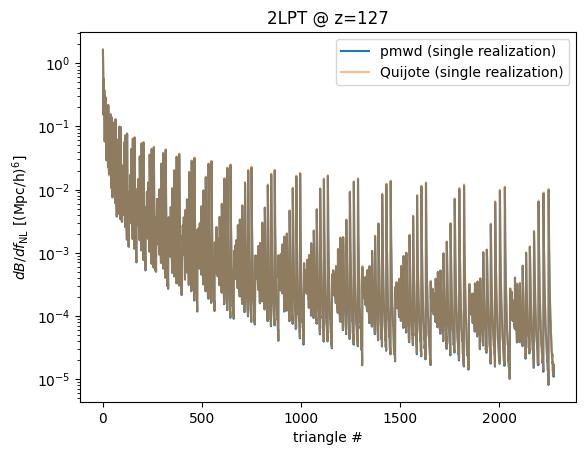

In [26]:
plt.semilogy((B_LC_p[:,-2] - B_LC_m[:,-2])/200.,label='pmwd (single realization)')
plt.semilogy((B_LC_p_Q[:,-2] - B_LC_m_Q[:,-2])/200.,label='Quijote (single realization)',alpha=.5)
# plt.semilogy((np.load("/home/fs72085/tsfloss/data/Quijote_Measurements_npy/Bk_LC_p_z0.npy")[:,:,-2].mean(0) -  np.load("/home/fs72085/tsfloss/data/Quijote_Measurements_npy/Bk_LC_m_z0.npy")[:,:,-2].mean(0))/200.,label='Quijote (mean over many)',alpha=.5)
plt.legend()
plt.ylabel("$dB/df_{\\rm NL}$ [(Mpc/h)$^6$]")
plt.xlabel("triangle #")
plt.title("2LPT @ z=127")
plt.show()

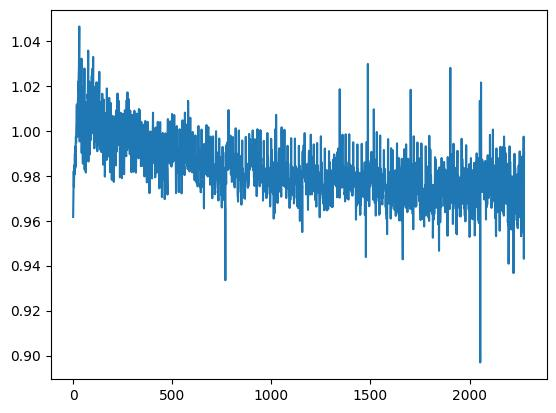

In [25]:
plt.plot(((B_LC_p[:,-2] - B_LC_m[:,-2])/200.) / ((B_LC_p_Q[:,-2] - B_LC_m_Q[:,-2])/200.))

Most of the remaining difference comes from the difference in transfer function of PMWD (Eisenstein-Hu) vs Quijote (CAMB)